##Importing required libraries

In [ ]:
import numpy as np
from google.colab import drive
import os

# Computer vision
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
# drive.mount('/content/gdrive')

# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# %cd /content/gdrive/My Drive/Kaggle

# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# !unzip -qq \*.zip  && rm *.zip

You can run the block above to download the dataset to your google drive account. For more info see [this article](https://www.kaggle.com/general/74235).
As I downloaded the dataset before, I just move to the downloaded folder.

In [ ]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Kaggle/chest_xray/chest_xray

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle/chest_xray/chest_xray


## Loading dataset from directory

In [ ]:
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  "./train",
  seed=123,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  shuffle=True,
)

Found 5216 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "./test",
  seed=123,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
)
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./val",
  seed=123,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
)

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


There is only 16 instances for validation set which is not enough. So I used test set as validation set.

In [ ]:
class_names = train_ds.class_names

## Plotting a number of pictures

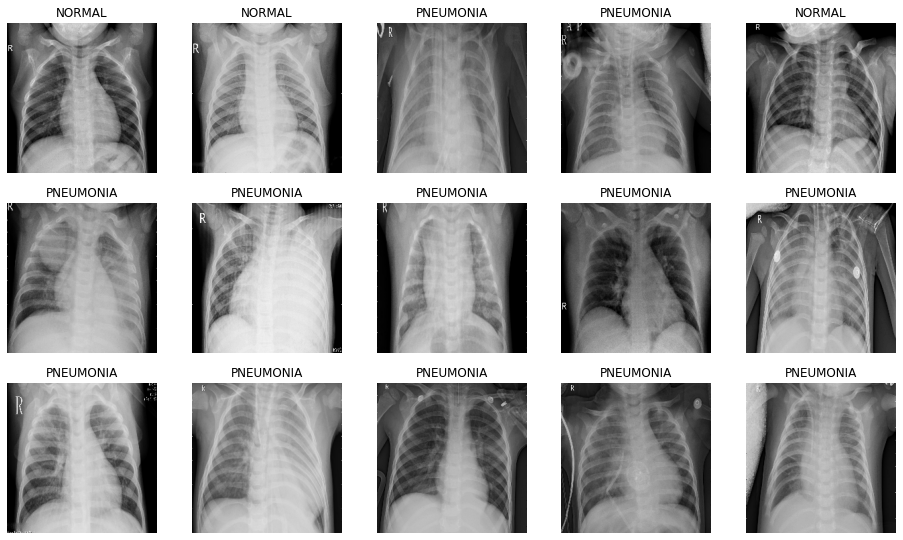

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i + 17].numpy().astype("uint8").reshape(224,224),cmap='gray')
    plt.title(class_names[labels[i + 17]])
    plt.axis("off")

#Defining the model

In [ ]:
model = tf.keras.Sequential([
  keras.Input(shape=(img_height,img_width,1)),

  # rescaling to (0, 1)
  layers.Rescaling(1./255),

  # data augmentation layers
  layers.RandomTranslation(height_factor = 0.1, width_factor = 0),
  layers.RandomTranslation(width_factor = 0.1,height_factor = 0),
  layers.RandomRotation(factor=0.1),
  layers.RandomZoom(height_factor = 0.1),

  # using ResNet50
  keras.applications.ResNet50(
    weights=None, input_shape=(img_height,img_width,1), classes=2
  )

])
model.build()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 1)       0         
                                                                 
 random_translation_6 (Rando  (None, 224, 224, 1)      0         
 mTranslation)                                                   
                                                                 
 random_translation_7 (Rando  (None, 224, 224, 1)      0         
 mTranslation)                                                   
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 1)       0         
                                                      

## Training the model

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
# cb = [ 
#     EarlyStopping(monitor = 'loss', patience = 7), 
#     ReduceLROnPlateau(monitor = 'loss', patience = 4), 
#     ModelCheckpoint('./model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
# ]

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit( train_ds,
                     validation_data = test_ds,
                     epochs=12,
                     callbacks=learning_rate_reduction
                    )

Epoch 1/12
163/163 [==============================] - 69s 380ms/step - loss: 0.3887 - accuracy: 0.8692 - val_loss: 7.1697 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 63s 374ms/step - loss: 0.2204 - accuracy: 0.9156 - val_loss: 6.0502 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9287
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 62s 375ms/step - loss: 0.1910 - accuracy: 0.9287 - val_loss: 5.5771 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 62s 375ms/step - loss: 0.1462 - accuracy: 0.9450 - val_loss: 2.9248 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9548
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [======================

## Results

In [ ]:
score = model.evaluate(test_ds, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 26.271596550941467%
Test accuracy: 91.50640964508057%
MLP Error: 8.49%
